# Running radioSphere on artificial data

In [1]:
import os, sys
import numpy
import radioSphere
import tifffile
import scipy.ndimage
import matplotlib
import matplotlib.pyplot as plt

# Plotting stuff
plt.style.use('../tools/radioSphere.mplstyle')
matplotlib.rcParams['figure.figsize'] = [10,6]

## Experimental parameters

In [2]:
GRAPH = False # flag to control showing all graphs within functions
verbose = True # flag to control showing extra information in this script

# Properties of the experimental setup
SOD = 20  # source to (middle of) object distance (mm)
SDD = 100 # source to detector panel distance (mm)

# Detector panel properties
pixelSizeDetectorMM = 0.1 # size of one pixel on the detector panel (mm)
detectorResolution = [512,512] # number of pixels on the detector panel (-)

# DEM parameters
radiusMM = 0.5 # particle radius, set in DEM script (mm)
DEM_output_file = '../data/radioSphereMonodisperseFlow.data'
samplingTransverseDistanceMM = 4 # how far from the centre of the image to draw particles
samplingThicknessXMM = 2 # how deep to sample particles in the beam direction (mm)
timeStepDEM = 20 # which time step to load

# radioSphere parameters
CORxIncPerRadius = 10 # how many increments per particle radius
blurPX = 0.0 # how much blur to add to the images, if any
noiseSigmaMM = 0.0 # standard deviation of noise level (mm)

# Derived values
zoomLevel = SDD/SOD # how much a particle is 'zoomed' because of the cone beam effect (-)
halfConeBeamAngleDegrees = numpy.degrees(numpy.arctan(radiusMM/SOD)) # defined in paper

## Generate artifical radiograph from MercuryDPM data that comes with radioSphere

Made radiograph for thickness 2 mm. It contains 118 particles.
Time step 20
Blur 0.0 px. Noise 0.0 mm.
SOD = 20.00 mm. Half beam angle = 27.11 degrees.


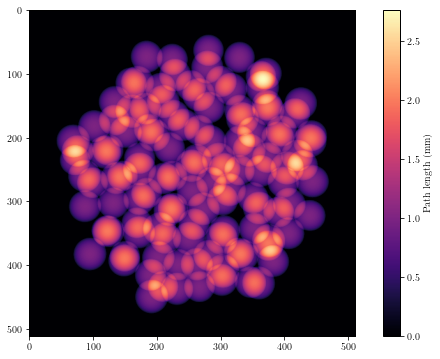

In [3]:
this_case = f'{samplingThicknessXMM}_{timeStepDEM}_{noiseSigmaMM}_{blurPX}'

radioMM, spheres_DEM, radiiMM, sourceObjectDistMM = radioSphere.mercury.generateSampledRadiographFromMercuryData(
    DEM_output_file,
    timeStepDEM,
    halfConeBeamAngleDegrees,
    pixelSizeDetectorMM,
    detectorResolution,
    zoomLevel=zoomLevel,
    samplingTransverseDistanceMM=samplingTransverseDistanceMM,
    samplingThicknessXMM=samplingThicknessXMM,
    GRAPH=GRAPH
    )
print(f"Made radiograph for thickness {samplingThicknessXMM} mm. It contains {len(spheres_DEM)} particles.")
print(f"Time step {timeStepDEM}")
print(f"Blur {blurPX} px. Noise {noiseSigmaMM} mm.")
print(f"SOD = {sourceObjectDistMM:.2f} mm. Half beam angle = {numpy.degrees(numpy.arctan(detectorResolution[0]*pixelSizeDetectorMM/sourceObjectDistMM/zoomLevel)):.2f} degrees.")

# blur first
if blurPX > 0: radioMM = scipy.ndimage.filters.gaussian_filter(radioMM, sigma=blurPX)
# Add mm noise
if noiseSigmaMM > 0: radioMM += numpy.random.normal(scale=noiseSigmaMM, size=radioMM.shape)

if verbose:
    plt.imshow(radioMM)
    cb = plt.colorbar()
    cb.set_label('Path length (mm)')
    plt.show()

## Do tomopack scan to find particle locations in 3D

Loading previous indicator functions... done.

Converting tomopack x-scan to 3D positions


tomopackDivergentScanTo3DPositions(): I'm returning 118 3D positions.

detectSpheres.calculateErrors(): number_lost = 1
Lost 1 particles with a typical error of 0.11977845269475211 mm.


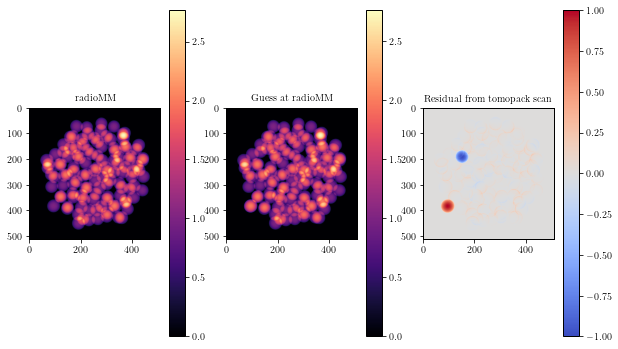

In [4]:
# Define the distances from the source at which we want to evaluate tomopack
CORxMin=sourceObjectDistMM-samplingThicknessXMM/2-4*radiiMM[0]
CORxMax=sourceObjectDistMM+samplingThicknessXMM/2+4*radiiMM[0]
CORxDelta=radiiMM[0]/CORxIncPerRadius
CORxNumber = numpy.int(numpy.ceil((CORxMax - CORxMin)/CORxDelta))

# Get the distance of every particle from the source
positionsXYZmm = radioSphere.detectSpheres.tomopackDivergentScanTo3DPositions(
    radioMM,
    radiiMM[0],
    CORxNumber=CORxNumber,
    CORxMin=CORxMin,
    CORxMax=CORxMax,
    massThreshold=0.1,
    maxIterations=500,
    scanFixedNumber=len(spheres_DEM),
    sourceDetectorDistMM=SDD,
    pixelSizeMM=pixelSizeDetectorMM,
    l=0.2,
    kTrustRatio=0.75,
    useCache=True,
    verbose=verbose,
    cacheFile=f'../cache/fXseriesDEM_{this_case}.tif'
    )

err_mean, err_std, number_lost = radioSphere.detectSpheres.calculateErrors(positionsXYZmm,spheres_DEM,radiiMM)

print(f'Lost {number_lost} particles with a typical error of {err_mean} mm.')

# Now generate a radiograph using the recovered positions
p_f_x = radioSphere.projectSphere.projectSphereMM(
    positionsXYZmm,
    radiiMM[0]*numpy.ones(len(positionsXYZmm)),
    sourceDetectorDistMM=zoomLevel*sourceObjectDistMM,
    pixelSizeMM=pixelSizeDetectorMM,
    detectorResolution=radioMM.shape
    )

# Calculate the current residual (difference between what we wanted and what we got)
residual = p_f_x - radioMM

if verbose:
    plt.clf()
    plt.subplot(1,3,1)
    plt.title("radioMM")
    plt.imshow(radioMM)
    plt.colorbar()

    plt.subplot(1,3,2)
    plt.title("Guess at radioMM")
    plt.imshow(p_f_x)
    plt.colorbar()

    plt.subplot(1,3,3)
    plt.title("Residual from tomopack scan")
    plt.imshow(residual, vmin=-1, vmax=1, cmap='coolwarm')
    plt.colorbar()

    plt.show()

## (Optional) optimisation step to get better particle locations

In [ ]:
positionsXYZmmOpt = radioSphere.optimisePositions.optimiseSensitivityFields(
    radioMM,
    positionsXYZmm,
    radiiMM[0]*numpy.ones(len(positionsXYZmm)),
    perturbationMM=(0.1, 0.05, 0.05),
    minDeltaMM=0.0001,
    iterationsMax=500,
    sourceDetectorDistMM=zoomLevel*sourceObjectDistMM,
    pixelSizeMM=pixelSizeDetectorMM,
    detectorResolution=radioMM.shape,
    verbose=verbose,
    )

p_f_x_Opt = radioSphere.projectSphere.projectSphereMM(
    positionsXYZmmOpt,
    radiiMM[0]*numpy.ones(len(positionsXYZmmOpt)),
    sourceDetectorDistMM=zoomLevel*sourceObjectDistMM,
    pixelSizeMM=pixelSizeDetectorMM,
    detectorResolution=radioMM.shape
    )


residualOpt = p_f_x_Opt - radioMM

if verbose:
    plt.clf()
    plt.subplot(2,2,1)
    plt.title("radioMM")
    plt.imshow(radioMM)
    plt.colorbar()

    plt.subplot(2,2,2)
    plt.title("Residual from tomopack $\psi$ scan 3D guess")
    plt.imshow(residual, vmin=-1, vmax=1, cmap='coolwarm')
    plt.colorbar()

    plt.subplot(2,2,3)
    plt.title("Residual after optimisation")
    plt.imshow(residualOpt, vmin=-1, vmax=1, cmap='coolwarm')
    plt.colorbar()

    plt.subplot(2,2,4)
    plt.title(r"Residual after optimisation ($\frac{1}{50}$ LUT range)")
    plt.imshow(residualOpt, vmin=-0.02, vmax=0.02, cmap='coolwarm')
    plt.colorbar()
    plt.show()

err_mean, err_std, number_lost = radioSphere.detectSpheres.calculateErrors(positionsXYZmmOpt,spheres_DEM,radiiMM)
print(f'Lost {number_lost} particles with a typical error of {err_mean} mm.')


	Iteration Number 390 |deltaMM|: 0.01667   |deltaMM|: 0.01567   |deltaMM|: 0.01459   |deltaMM|: 0.01397   |deltaMM|: 0.01302   |deltaMM|: 0.01198   |deltaMM|: 0.01169   |deltaMM|: 0.01092   |deltaMM|: 0.00973   |deltaMM|: 0.00976   |deltaMM|: 0.00914   |deltaMM|: 0.00865   |deltaMM|: 0.00831   |deltaMM|: 0.00781   |deltaMM|: 0.00763   |deltaMM|: 0.00749   |deltaMM|: 0.00728   |deltaMM|: 0.00698   |deltaMM|: 0.00660   |deltaMM|: 0.00651   |deltaMM|: 0.00613   |deltaMM|: 0.00587   |deltaMM|: 0.00569   |deltaMM|: 0.00561   |deltaMM|: 0.00557   |deltaMM|: 0.00547   |deltaMM|: 0.00506   |deltaMM|: 0.00539   |deltaMM|: 0.00513   |deltaMM|: 0.00492   |deltaMM|: 0.00485   |deltaMM|: 0.00482   |deltaMM|: 0.00485   |deltaMM|: 0.00474   |deltaMM|: 0.00477   |deltaMM|: 0.00423   |deltaMM|: 0.00471   |deltaMM|: 0.00410   |deltaMM|: 0.00451   |deltaMM|: 0.00465   |deltaMM|: 0.00448   |deltaMM|: 0.00449   |deltaMM|: 0.00402   |deltaMM|: 0.00456   |deltaMM|: 0.00463   |deltaMM|: 0.00452   |deltaMM|: 0

	Iteration Number 436   |deltaMM|: 0.00203   |deltaMM|: 0.00192   |deltaMM|: 0.00196   |deltaMM|: 0.00197   |deltaMM|: 0.00198   |deltaMM|: 0.00199   |deltaMM|: 0.00197   |deltaMM|: 0.00209   |deltaMM|: 0.00220   |deltaMM|: 0.00217   |deltaMM|: 0.00184   |deltaMM|: 0.00200   |deltaMM|: 0.00199   |deltaMM|: 0.00196   |deltaMM|: 0.00197   |deltaMM|: 0.00198   |deltaMM|: 0.00205   |deltaMM|: 0.00212   |deltaMM|: 0.00212   |deltaMM|: 0.00177   |deltaMM|: 0.00219   |deltaMM|: 0.00182   |deltaMM|: 0.00186   |deltaMM|: 0.00193   |deltaMM|: 0.00181   |deltaMM|: 0.00191   |deltaMM|: 0.00183   |deltaMM|: 0.00187   |deltaMM|: 0.00175   |deltaMM|: 0.00190   |deltaMM|: 0.00185   |deltaMM|: 0.00188   |deltaMM|: 0.00182   |deltaMM|: 0.00189   |deltaMM|: 0.00174   |deltaMM|: 0.00181   |deltaMM|: 0.00184   |deltaMM|: 0.00182   |deltaMM|: 0.00177   |deltaMM|: 0.00176   |deltaMM|: 0.00178   |deltaMM|: 0.00173   |deltaMM|: 0.00167   |deltaMM|: 0.00173   |deltaMM|: 0.00174